In [1]:
# Library & Constants

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Options
# The following options can be modified to change the behavior of the script. These are made for the user to easily change the behavior of the script without having to modify the code.

XGB_FEATER_SELECTION = True 
# If True, the script will use the feature selection method of XGBoost to select the most important features. Otherwise, the script will use the feature selection method of the Random Forest.

BINARY_CLASSIFICATION = True
# If True, the script will perform a binary classification. Otherwise, the script will perform a multiclass classification.

CLASS_SELECTION = []
# You can specify the classes you want to use for the multiclass classification. If you want to use all the classes, you can leave it empty.

THRESHOLD = 0.005
# The threshold value to be used for feature selection. The features with importance values greater than this threshold value will be selected.


# Paths

DATASET_DIR = '../data/CIC'
MODEL_DIR = '../models'

# Datsets Info

MAPPING_BINARY_LABELS = ['Benign', 'Malicious']
BINARY_LABELS = {
    0: 'Benign',
    1: 'Malicious'
}

MAPPING_MULTICLASS_LABELS = {
    0: 'Benign',
    1: 'Web Attack',
    2: 'DoS Attack',
    3: 'Network Attack',
    4: 'Botnet',
    5: 'Service Attack'
}
MULTICLASS_LABELS = {
    0: ['Benign'],
    1: ["Web_XSS", "Web_SQL_Injection", "Web_Brute_Force"],                                 # Web Attack
    2: ["DoS_Slowhttptest", "DoS_GoldenEye", "DDoS_LOIT", "DoS_Hulk", "DoS_Slowloris"],     # DoS Attack
    3: ["Port_Scan", "Heartbleed"],                                                         # Network Attack        
    4: ["Botnet_ARES"],                                                                     # Botnet
    5: ["SSH-Patator", "FTP-Patator"]                                                       # Service Attack                                           
}

# Dataset

In [2]:
# Load Data

def load_data(datasets_dir: str) -> pd.DataFrame:
    """
    Load all datasets from a directory into a single DataFrame

    :param str datasets_dir: directory containing the datasets
    :return: pd.DataFrame containing all datasets
    """

    data = []
    for file in os.listdir(datasets_dir):
        if file.endswith('.csv'):
            data.append(pd.read_csv(os.path.join(datasets_dir, file)))

    return pd.concat(data, ignore_index=True)


if __name__ == '__main__':
    dataset = load_data(DATASET_DIR)    

## Data Exploration

In [ ]:
# Plot Data

def plot_attacks_distribution(target: pd.DataFrame):
    """
    Generates a bar chart to visualize the distribution of attack labels in the given dataset.

    :param pd.DataFrame dataset: The dataset containing the 'label' column to generate the pie chart from.
    """

    with plt.style.context('dark_background'):
        attack_data = dataset[~dataset['label'].isin(MAPPING_BINARY_LABELS)]['label'].value_counts()
        
        fig, ax = plt.subplots(figsize=(26, 10))
        ax.bar(attack_data.index, attack_data.values, width=0.3)
        plt.show()

    plt.close()
    

def plot_distribution(dataset: pd.DataFrame):
    """
    Generates a pie chart to visualize the distribution of 'Benign' and 'Attack' labels in the given dataset.

    :param pd.DataFrame dataset: The dataset containing the 'label' column to generate the pie chart from.
    """

    with plt.style.context('dark_background'):
        data = {
            'Benign': dataset['label'].isin(MAPPING_BINARY_LABELS).sum(),
            'Malicius': dataset[~dataset['label'].isin(MAPPING_BINARY_LABELS)]['label'].value_counts().sum()
        }
        plt.figure(figsize=(10, 10))
        plt.pie(data.values(), labels=data.keys(), autopct='%1.1f%%', startangle=140, colors=['#66b3ff', '#D4FCC3'])
        plt.axis('equal')
        plt.show()

    plt.close()


if __name__ == '__main__':
    plot_distribution(dataset)
    plot_attacks_distribution(dataset)

## Data Preparation

Before cleaning:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2438052 entries, 0 to 2438051
Columns: 122 entries, flow_id to label
dtypes: float64(61), int64(55), object(6)
memory usage: 2.2+ GB
None

After cleaning:
<class 'pandas.core.frame.DataFrame'>
Index: 2435692 entries, 0 to 2438051
Columns: 117 entries, dst_port to label
dtypes: float64(61), int64(54), object(2)
memory usage: 2.1+ GB
None


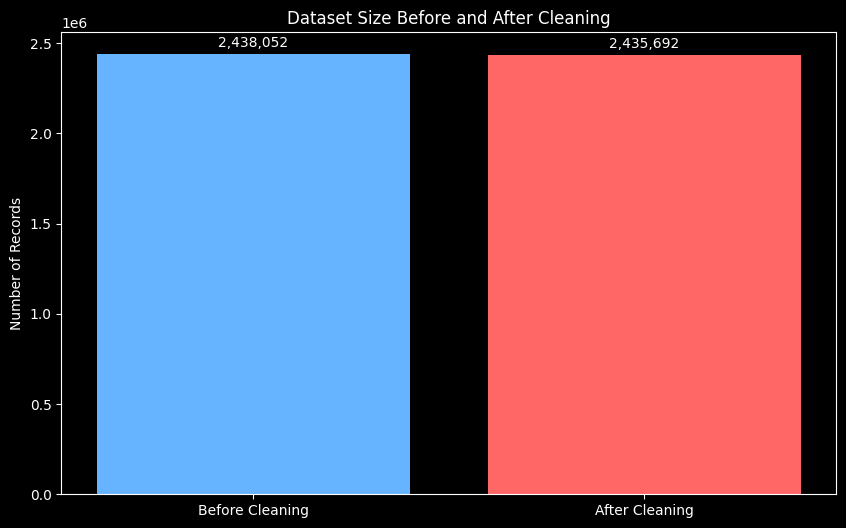

In [3]:
# Data Cleaning
from typing import List

def clean_data(dataset: pd.DataFrame, columns_to_remove: List[str]) -> pd.DataFrame:
    """
    Cleans the given dataset.

    :param pd.DataFrame dataset: The dataset to clean.
    :param List[str] columns_to_remove: The columns to remove from the dataset.
    :return: The cleaned dataset.
    """

    dataset = dataset.dropna()
    dataset = dataset.drop_duplicates()

    dataset = dataset.replace([np.inf, -np.inf], np.nan)
    float_cols = dataset.select_dtypes(include=['float']).columns
    dataset[float_cols] = dataset[float_cols].round(4)

    dataset = dataset.drop(columns=columns_to_remove)
    
    if len(CLASS_SELECTION) > 0:
        dataset = dataset[dataset['label'].isin(CLASS_SELECTION)]

    return dataset


def plot_data_size_comparison(length_before: int, length_after: int):
    """
    Plots a bar chart to compare the size of the dataset before and after cleaning.

    :param int length_before: The length of the dataset before cleaning.
    :param int length_after: The length of the dataset after cleaning.
    """
    with plt.style.context('dark_background'):
        fig, ax = plt.subplots(figsize=(10, 6))
        bars = ax.bar(['Before Cleaning', 'After Cleaning'], [length_before, length_after], color=['#66b3ff', '#ff6666'])
        ax.set_title('Dataset Size Before and After Cleaning')
        ax.set_ylabel('Number of Records')

        # Add text annotations to the bars
        for bar in bars:
            height = bar.get_height()
            ax.annotate(f'{height:,}',
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')

        plt.show()

    plt.close()

if __name__ == '__main__':
    print("Before cleaning:")
    print(dataset.info())
    length_before = len(dataset)

    columns_to_remove = ["flow_id", "src_ip", "dst_ip", "src_port", "timestamp"]
    dataset = clean_data(dataset, columns_to_remove)

    print("\nAfter cleaning:")
    print(dataset.info())

    plot_data_size_comparison(length_before, len(dataset))

In [ ]:
# Data Labeling

def binary_labeling(dataset: pd.DataFrame) -> pd.DataFrame:
    """
    Converts the 'label' column in the given dataset to binary labels.
    0 for benign and 1 for malicious.

    :param pd.DataFrame dataset: The dataset to convert.
    :return: The dataset with binary labels.
    """

    dataset['label'] = dataset['label'].apply(lambda x: 0 if x in MAPPING_BINARY_LABELS else 1)

    return dataset

def multiclass_labeling(dataset: pd.DataFrame, mapping_label: dict) -> pd.DataFrame:
    """
    Converts the 'label' column in the given dataset to multiclass labels.

    :param pd.DataFrame dataset: The dataset to convert.
    :param dict mapping_label: The mapping of labels to convert to.
    :return: The dataset with multiclass labels.
    """

    dataset['label'] = dataset['label'].map(mapping_label)
    return dataset


if __name__ == '__main__':
    print(f"Before {"Binary" if BINARY_CLASSIFICATION else 'Multiclass'} labeling:")
    print(dataset['label'].value_counts())

    if BINARY_CLASSIFICATION:
        dataset = binary_labeling(dataset)
    else:
        group_map = {attack: group for group, attacks in MULTICLASS_LABELS.items() for attack in attacks}
        dataset = multiclass_labeling(dataset, group_map)

    print(f"\nAfter {"Binary" if BINARY_CLASSIFICATION else 'Multiclass'} labeling:")
    print(f"\t[Mapping] {BINARY_LABELS if BINARY_CLASSIFICATION else MAPPING_MULTICLASS_LABELS}")
    print(dataset['label'].value_counts())

In [6]:
# Splitting Features and Labels
from typing import Tuple


def extract_feature_and_target(dataset: pd.DataFrame) -> Tuple[pd.DataFrame, pd.Series]:
    """
    Extracts the feature and target columns from the given dataset.

    :param pd.DataFrame dataset: The dataset to extract the feature and target columns from.
    :return: The feature and target columns.
    """

    return dataset.drop(columns=['label']), dataset['label']


if __name__ == '__main__':
    X, y = extract_feature_and_target(dataset)

    del dataset

In [ ]:
# Plotting before Data Balancing

def plot_attacks_distribution(target: pd.Series, mapping: list):
    """
    Generates a bar chart to visualize the distribution of attack labels in the given dataset.

    :param pd.DataFrame dataset: The dataset containing the 'label' column to generate the pie chart from.
    :param dict mapping: The mapping of labels to convert to.
    """

    with plt.style.context('dark_background'):
        attack_data = target.value_counts()
        attack_data.index = attack_data.index.map(mapping)

        fig, ax = plt.subplots(figsize=(26, 10))
        ax.bar(attack_data.index, attack_data.values, width=0.3)
        plt.show()

    plt.close()
    

def plot_distribution(target: pd.Series, mapping: dict):
    """
    Generates a pie chart to visualize the distribution of 'Benign' and 'Attack' labels in the given dataset.

    :param pd.DataFrame dataset: The dataset containing the 'label' column to generate the pie chart from.
    :param dict mapping: The mapping of labels to convert to.
    """

    with plt.style.context('dark_background'):
        data = target.value_counts()
        data.index = data.index.map(mapping)

        plt.figure(figsize=(10, 10))
        plt.pie(data.values, labels=data.index, autopct='%1.1f%%', startangle=140, colors=['#66b3ff', '#D4FCC3'])
        plt.axis('equal')
        plt.show()

    plt.close()


if __name__ == '__main__':    
    if BINARY_CLASSIFICATION:
        plot_distribution(y, BINARY_LABELS)
    else:
        plot_attacks_distribution(y, MAPPING_MULTICLASS_LABELS)

In [8]:
# Data Balancing

from imblearn.under_sampling import RandomUnderSampler

def balance_data_binary(dataset: pd.DataFrame, target: pd.Series) -> Tuple[pd.DataFrame, pd.Series]:
    """
    Balances the given dataset using RandomUnderSampler.

    :param pd.DataFrame dataset: The dataset to balance.
    :param pd.Series target: The target column to balance.
    :return: The balanced dataset and target.
    """

    rus = RandomUnderSampler(random_state=42)
    X_resampled, y_resampled = rus.fit_resample(dataset, target)

    return X_resampled, y_resampled


if __name__ == '__main__':
    X, y = balance_data_binary(X, y)

In [ ]:
# Plotting after Data Balancing

if __name__ == '__main__':
    if BINARY_CLASSIFICATION:
        plot_distribution(y, BINARY_LABELS)
    else:
        plot_attacks_distribution(y, MAPPING_MULTICLASS_LABELS)

In [10]:
# One Hot Encoding
from sklearn.preprocessing import OneHotEncoder


def one_hot_encoding_dataset(dataset: pd.DataFrame) -> pd.DataFrame:
    """
    Applies one-hot encoding to all columns of type "object" in a pandas DataFrame.

    :param pd.DataFrame dataset: The DataFrame to apply one-hot encoding to.
    :return: The DataFrame with one-hot encoding applied.
    """

    object_columns = dataset.select_dtypes(include=['object']).columns

    encoder = OneHotEncoder(sparse_output=False)

    encoded_array = encoder.fit_transform(dataset[object_columns])
    encoded_columns = encoder.get_feature_names_out(object_columns)
    encoded_df = pd.DataFrame(encoded_array, columns=encoded_columns)
    dataset = pd.concat(
        [dataset.drop(columns=object_columns).reset_index(drop=True), encoded_df.reset_index(drop=True)],
        axis=1
    )

    return dataset


if __name__ == '__main__':
    X = one_hot_encoding_dataset(X)

In [ ]:
# Data Preprocessing
from sklearn.preprocessing import MinMaxScaler


def normalize_data(dataset: pd.DataFrame) -> pd.DataFrame:
    """
    Normalizes the given dataset using Min-Max scaling.

    :param pd.DataFrame dataset: The dataset to normalize.
    :return: The normalized dataset.
    """

    scaler = MinMaxScaler()
    normalized_array = scaler.fit_transform(dataset)

    normalized_df = pd.DataFrame(normalized_array, columns=dataset.columns, index=dataset.index)
    return normalized_df

if __name__ == '__main__':
    X = normalize_data(X)

In [ ]:
# Feature Selection

from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel


def select_features(dataset: pd.DataFrame, target: pd.Series, binary_classification: bool, threshold: float = 0.01, using_xgb: bool = True) -> pd.DataFrame:
    """
    Selects the most important features from the given dataset using a tree-based model.

    :param pd.DataFrame dataset: The dataset to select features from.
    :param pd.Series target: The target column.
    :param bool binary_classification: Whether the task is binary classification or not.
    :param float threshold: The threshold to use for feature selection.
    :param bool using_xgb: Whether to use XGBoost for feature selection or not.
    :return: The selected features.
    """

    if using_xgb:
        if binary_classification:
            clf = XGBClassifier(eval_metric='logloss', random_state=42, objective='binary:logistic')
        else:
            clf = XGBClassifier(eval_metric='mlogloss', random_state=42, objective='multi:softmax')
    else:
        clf = RandomForestClassifier(n_estimators=100, random_state=42)
    
    clf.fit(dataset, target)
    feature_importances = clf.feature_importances_
    sfm = SelectFromModel(clf, threshold=threshold, prefit=True)
    selected_features = dataset.columns[sfm.get_support()]
    feature_scores = {feature: importance for feature, importance in zip(dataset.columns, feature_importances) if importance >= threshold}

    return selected_features, feature_scores


if __name__ == '__main__':
    features_name, features_scored = select_features(X, y, BINARY_CLASSIFICATION, using_xgb=XGB_FEATER_SELECTION, threshold=THRESHOLD)
    num_features = len(features_name)

    print(f"Selected features with threshold >= {THRESHOLD} ({num_features} features):")
    for feature, score in sorted(features_scored.items(), key=lambda x: x[1], reverse=True):
        print(f"\t{feature}\t{score:.4f}")

    X = X[features_name]
    print("Dataset after Feature Selection:")
    print(X.info())


# Modelling
Procederemo con lo sviluppo del modello facendo riferimento progetto github [_"Efficient-CNN-BiLSTMs"_](https://github.com/jayxsinha/Efficient-CNN-BiLSTM-for-Network-IDS/) per la sua struttura

In [13]:
# Data Splitting

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# The neural network model works only wiht numpy arrays, so we need to convert the dataframes to numpy arrays 
X_train = X_train.to_numpy()
X_test = X_test.to_numpy()
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

# Moreover, the neural network model has a specific input shape, so we need to reshape the data
X_train = X_train.reshape((-1, num_features, 1))
X_test = X_test.reshape((-1, num_features, 1))

del X, y

## Model Desing

I layer di questo modello sono i seguenti:
- CNN: Utile per apprendere le relazioni più nascoste tra le feature
- 2 LSTMs: Per poter capire come le feature hanno effetto su lungo raggio

In [ ]:
# Model Design
from keras.models import Sequential
from keras.layers import (Convolution1D, MaxPooling1D, BatchNormalization, Bidirectional, LSTM, 
    Dropout, Dense, Activation, RepeatVector)

def build_model(input_shape=(122, 1)):
    model = Sequential()
    
    # 1D Convolutional layer
    model.add(Convolution1D(64, kernel_size=3, padding="same", activation="relu", input_shape=input_shape))
    model.add(MaxPooling1D(pool_size=2))
    model.add(BatchNormalization())
    
    # Bidirectional LSTM layer
    model.add(Bidirectional(LSTM(64, return_sequences=False)))
    model.add(Dropout(0.3))
    model.add(BatchNormalization())
    
    # RepeatVector to adapt dimensions
    model.add(RepeatVector(1))  # Ripete il vettore per adattarlo al prossimo LSTM
    
    # Second Bidirectional LSTM layer
    model.add(Bidirectional(LSTM(64, return_sequences=False)))
    model.add(Dropout(0.5))
    model.add(BatchNormalization())
    
    # Dense output layer with sigmoid activation
    model.add(Dense(1, activation='sigmoid'))
    
    # Compile the model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model



if __name__ == '__main__':
    model = build_model(input_shape=(num_features, 1 ))

    print("Model Summary:")
    print(model.summary())

In [ ]:
# Model Training

from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import KFold
from keras.callbacks import EarlyStopping

def train_model(model, X_train, y_train, batch_size=32, epochs=10, patience=3, validation_data=None):
    """
    Trains the given model with early stopping.

    :param keras.models.Sequential model: The model to train.
    :param np.ndarray X_train: The training features.
    :param np.ndarray y_train: The training target.
    :param int batch_size: The batch size for training.
    :param int epochs: The number of epochs for training.
    :param Tuple[np.ndarray, np.ndarray] validation_data: The validation features and target.
    :return: The trained model and training history.
    """

    early_stopping = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)

    history = model.fit(
        X_train, y_train,
        batch_size=batch_size,
        epochs=epochs,
        validation_data=validation_data,
        callbacks=[early_stopping]
    )
    return model, history


if __name__ == '__main__':
    model, history = train_model(model, X_train, y_train, epochs=100, patience=5, validation_data=(X_test, y_test))

In [ ]:
# Training Evaluation

def plot_training_metrics(history) -> plt.Figure:
    """
    Plots training and validation metrics from the history object.

    :param history: The training history object.
    :return: Matplotlib figure of the training metrics.
    """
    fig, ax = plt.subplots(1, 2, figsize=(14, 6))

    # Accuracy Plot
    train_acc = history.history.get('accuracy', None)
    val_acc = history.history.get('val_accuracy', None)
    if train_acc and val_acc:
        ax[0].plot(train_acc, label='Training Accuracy', marker='o')
        ax[0].plot(val_acc, label='Validation Accuracy', marker='x')
        ax[0].set_title('Training and Validation Accuracy per Epoch')
        ax[0].set_xlabel('Epochs')
        ax[0].set_ylabel('Accuracy')
        ax[0].legend()
        ax[0].grid(True)

    # Loss Plot
    train_loss = history.history['loss']
    val_loss = history.history.get('val_loss', None)
    ax[1].plot(train_loss, label='Training Loss', marker='o')
    if val_loss:
        ax[1].plot(val_loss, label='Validation Loss', marker='x')
    ax[1].set_title('Training and Validation Loss per Epoch')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Loss')
    ax[1].legend()
    ax[1].grid(True)

    plt.show()
    plt.close()

    return fig


if __name__ == '__main__':
    plot_history = plot_training_metrics(history)

In [ ]:
# Evaluation Metrics
from sklearn.metrics import confusion_matrix, roc_curve, auc, accuracy_score, f1_score
import seaborn as sns

def plot_evaluation_metrics(y_test, y_pred, y_pred_probs, is_binary=True, target_mapping=None) -> plt.Figure:
    """
    Plots the confusion matrix and ROC curve for the given predictions.

    :param np.ndarray y_test: The true target labels.
    :param np.ndarray y_pred: The predicted target labels.
    :param np.ndarray y_pred_probs: The predicted target probabilities.
    :param bool is_binary: Whether the classification is binary or multiclass.
    :param dict target_mapping: The mapping of target labels.
    :return: Matplotlib figure of the evaluation metrics.
    """

    if is_binary:
        fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    else:
        fig, ax = plt.subplots(1, 1, figsize=(8, 8))

    if target_mapping:
        labels = [target_mapping.get(label, label) for label in np.unique(y_test)]
    else:
        labels = np.unique(y_test)

    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
                xticklabels=labels, yticklabels=labels, 
                ax=axes[0] if is_binary else ax)
    
    if is_binary:
        axes[0].set_xlabel("Predicted")
        axes[0].set_ylabel("Original")
        axes[0].set_title("Confusion Matrix")
    else:
        ax.set_xlabel("Predicted")
        ax.set_ylabel("Original")
        ax.set_title("Confusion Matrix")

    if is_binary:
        fpr, tpr, _ = roc_curve(y_test, y_pred_probs)
        roc_auc = auc(fpr, tpr)
        axes[1].plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.2f})", color="darkorange")
        axes[1].plot([0, 1], [0, 1], color="navy", linestyle="--")
        axes[1].set_xlabel("False Positive Rate")
        axes[1].set_ylabel("True Positive Rate")
        axes[1].set_title("Receiver Operating Characteristic")
        axes[1].legend(loc="lower right")
        
    plt.show()
    plt.close()

    return fig

def evaluate_model(model, X_test, y_test, is_binary=True, target_mapping=None) -> plt.Figure:
    """
    Evaluates the given model using the test data and plots the evaluation metrics.

    :param keras.models.Sequential model: The trained model to evaluate.
    :param np.ndarray X_test: The test features.
    :param np.ndarray y_test: The test target.
    :param bool is_binary: Whether the classification is binary or multiclass.
    :param dict target_mapping: The mapping of target labels.
    :return: Matplotlib figure of the evaluation metrics.
    """


    if is_binary:
        y_pred_probs = model.predict(X_test).ravel()
        y_pred = (y_pred_probs >= 0.5).astype(int)
    else:
        y_pred_probs = model.predict(X_test)
        y_pred = np.argmax(y_pred_probs, axis=1)

    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average="weighted")
    print(f"Accuracy: {accuracy:.2f}")
    print(f"F1 Score (Weighted): {f1:.2f}")

    return plot_evaluation_metrics(y_test, y_pred, y_pred_probs, is_binary, target_mapping)


if __name__ == '__main__':
    plot_cm_and_roc = evaluate_model(model, X_test, y_test, is_binary=BINARY_CLASSIFICATION, target_mapping=BINARY_LABELS if BINARY_CLASSIFICATION else MAPPING_MULTICLASS_LABELS)

In [19]:
# Save Model
import json

def save_model(model, features: list, mapping_used: list, plots: dict, path: str = "../models"):
    """
    Saves the given model, features, and plots to the specified path.

    :param keras.models.Sequential model: The model to save.
    :param list features: The list of features used by the model.
    :param dict plots: A dictionary of plots to save.
    :param str path: The path to save the model to.
    """

    if not os.path.exists(path):
        os.makedirs(path)

    version = len(os.listdir(path)) + 1
    model_dir = os.path.join(path, f"v{version}")

    os.makedirs(model_dir)

    # Save the model
    model.save(os.path.join(model_dir, "model.keras"))

    # Save the features as a JSON file
    with open(os.path.join(model_dir, "features.json"), "w") as f:
        json.dump(features, f, indent=4)

    # Save the mapping used as a JSON file
    with open(os.path.join(model_dir, "mapping.json"), "w") as f:
        json.dump(mapping_used, f, indent=4)

    # Save the plots
    for name, plot in plots.items():
        plot.savefig(os.path.join(model_dir, f"{name}.png"))


if __name__ == '__main__':
    figure_dict = {
        "plot_cm_and_roc": plot_cm_and_roc,
        "plot_history": plot_history    
    }

    save_model(model, features_name, BINARY_LABELS if BINARY_CLASSIFICATION else MAPPING_MULTICLASS_LABELS, figure_dict, MODEL_DIR)
